In [48]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def plot_unbalance(selection: str):
    """
    Plot the unbalance for a given account or strategy.
    
    Parameters:
    - selection (str): The name of the account (e.g., 'test1') or strategy (e.g., 'pairs1') to plot.
    
    If selection is an account, plots the account's total unbalance and the unbalance of all associated strategies.
    If selection is a strategy, plots only the strategy's unbalance.
    """
    # Load configuration
    config_file = 'config_test.json'
    try:
        with open(config_file, 'r') as f:
            config = json.load(f)
    except FileNotFoundError:
        print(f"Error: Config file {config_file} not found.")
        return
    
    output_dir = config.get('output_directory', 'output_bin/')
    if not os.path.exists(output_dir):
        print(f"Error: Output directory {output_dir} does not exist.")
        return
    
    # Extract accounts and strategies
    strategies = list(config.get('strategy', {}).keys())
    accounts = list(config.get('account_allocation', {}).keys())
    
    # Validate selection
    is_account = selection in accounts
    is_strategy = selection in strategies
    
    if not (is_account or is_strategy):
        print(f"Error: '{selection}' is neither a valid account nor a strategy.")
        return
    
    # Collect unbalance data
    timestamps = set()
    unbalance_data = {}
    
    if is_account:
        # Plot for the account and its strategies
        account = selection
        
        # Load account portfolio
        account_portfolio_file = f"{output_dir}portfolio_{account}.json"
        try:
            with open(account_portfolio_file, 'r') as f:
                account_portfolio = json.load(f)
            unbalance_data[account] = {}
            for ts, data in account_portfolio.items():
                unbalance_data[account][ts] = data.get('portfolio_unbalance', 0.0)
                timestamps.add(ts)
        except FileNotFoundError:
            print(f"Error: Account portfolio file {account_portfolio_file} not found.")
            return
        
        # Load portfolios for all strategies under this account
        for strat_name, strat_config in config['strategy'].items():
            if strat_config.get('account_trade') == account and strat_config.get('active', False):
                portfolio_file = f"{output_dir}portfolio_{strat_name}.json"
                try:
                    with open(portfolio_file, 'r') as f:
                        portfolio = json.load(f)
                    unbalance_data[strat_name] = {}
                    for ts, data in portfolio.items():
                        unbalance_data[strat_name][ts] = data.get('portfolio_unbalance', 0.0)
                        timestamps.add(ts)
                except FileNotFoundError:
                    print(f"Warning: Portfolio file {portfolio_file} not found. Skipping strategy {strat_name}.")
    
    else:
        # Plot only for the selected strategy
        strat_name = selection
        portfolio_file = f"{output_dir}portfolio_{strat_name}.json"
        try:
            with open(portfolio_file, 'r') as f:
                portfolio = json.load(f)
            unbalance_data[strat_name] = {}
            for ts, data in portfolio.items():
                unbalance_data[strat_name][ts] = data.get('portfolio_unbalance', 0.0)
                timestamps.add(ts)
        except FileNotFoundError:
            print(f"Error: Portfolio file {portfolio_file} not found.")
            return
    
    # Plotting
    if not timestamps:
        print("No timestamps found for plotting.")
        return
    
    # Convert timestamps to datetime and sort
    try:
        timestamps_dt = sorted([
            datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in timestamps
        ])
        timestamp_strings = sorted(timestamps)
    except ValueError as e:
        print(f"Error: Invalid timestamp format in portfolio files. {e}")
        return
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot unbalance for each series
    for label, unbalances in unbalance_data.items():
        # Collect points only where data exists
        ts_points = []
        values = []
        for ts, ts_dt in zip(timestamp_strings, timestamps_dt):
            if ts in unbalances:
                ts_points.append(ts_dt)
                values.append(unbalances[ts])
        plt.plot(ts_points, values, marker='o', markersize=3, label=label)  # Small points with lines
    
    plt.xlabel('Timestamp')
    plt.ylabel('Portfolio Unbalance (Sum of Quantities)')
    plt.title(f'Portfolio Unbalance for {selection}' + (' and Strategies' if is_account else ''))
    plt.legend()
    plt.grid(True)
    
    # Limit x-axis ticks to 5
    if len(timestamps_dt) > 5:
        tick_indices = [int(i * (len(timestamps_dt) - 1) / 4) for i in range(5)]
        plt.xticks([timestamps_dt[i] for i in tick_indices], rotation=45)
    else:
        plt.xticks(timestamps_dt, rotation=45)
    
    # Format x-axis with datetime
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d %H:%M:%S'))
    
    plt.tight_layout()
    
    # Display the plot
    plt.show()

def plot_pnl(selection: str):
    """
    Plot the cumulative realized PNL for a given account or strategy.
    
    Parameters:
    - selection (str): The name of the account (e.g., 'test1') or strategy (e.g., 'pairs1') to plot.
    
    If selection is an account, plots the cumulative PNL for the account (sum of strategies) and each associated strategy.
    If selection is a strategy, plots only the strategy's cumulative PNL.
    """
    # Load configuration
    config_file = 'config_test.json'
    try:
        with open(config_file, 'r') as f:
            config = json.load(f)
    except FileNotFoundError:
        print(f"Error: Config file {config_file} not found.")
        return
    
    output_dir = config.get('output_directory', 'output_bin/')
    if not os.path.exists(output_dir):
        print(f"Error: Output directory {output_dir} does not exist.")
        return
    
    # Extract accounts and strategies
    strategies = list(config.get('strategy', {}).keys())
    accounts = list(config.get('account_allocation', {}).keys())
    
    # Validate selection
    is_account = selection in accounts
    is_strategy = selection in strategies
    
    if not (is_account or is_strategy):
        print(f"Error: '{selection}' is neither a valid account nor a strategy.")
        return
    
    # Collect PNL data
    timestamps = set()
    pnl_data = {}
    
    if is_account:
        # Plot for the account and its strategies
        account = selection
        
        # Load closed positions for all strategies under this account
        for strat_name, strat_config in config['strategy'].items():
            if strat_config.get('account_trade') == account and strat_config.get('active', False):
                closed_file = f"{output_dir}closed_positions_{strat_name}.json"
                try:
                    with open(closed_file, 'r') as f:
                        closed_positions = json.load(f)
                    pnl_data[strat_name] = {}
                    for exit_time, positions in closed_positions.items():
                        pnl = sum(pos['realized_pnl'] for pos in positions)
                        pnl_data[strat_name][exit_time] = pnl
                        timestamps.add(exit_time)
                except FileNotFoundError:
                    print(f"Warning: Closed positions file {closed_file} not found. Skipping strategy {strat_name}.")
        
        # Calculate account PNL as sum of strategy PNLs
        pnl_data[account] = {}
        for ts in timestamps:
            account_pnl = sum(
                pnl_data.get(strat_name, {}).get(ts, 0.0)
                for strat_name in pnl_data
                if strat_name != account
            )
            pnl_data[account][ts] = account_pnl
    
    else:
        # Plot only for the selected strategy
        strat_name = selection
        closed_file = f"{output_dir}closed_positions_{strat_name}.json"
        try:
            with open(closed_file, 'r') as f:
                closed_positions = json.load(f)
            pnl_data[strat_name] = {}
            for exit_time, positions in closed_positions.items():
                pnl = sum(pos['realized_pnl'] for pos in positions)
                pnl_data[strat_name][exit_time] = pnl
                timestamps.add(exit_time)
        except FileNotFoundError:
            print(f"Error: Closed positions file {closed_file} not found.")
            return
    
    # Compute cumulative PNL
    cumulative_pnl_data = {}
    for label, pnls in pnl_data.items():
        cumulative_pnl_data[label] = {}
        total_pnl = 0.0
        for ts in sorted(pnls.keys()):
            total_pnl += pnls[ts]
            cumulative_pnl_data[label][ts] = total_pnl
    
    # Plotting
    if not timestamps:
        print("No timestamps found for plotting.")
        return
    
    # Convert timestamps to datetime and sort
    try:
        timestamps_dt = sorted([
            datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in timestamps
        ])
        timestamp_strings = sorted(timestamps)
    except ValueError as e:
        print(f"Error: Invalid timestamp format in closed positions files. {e}")
        return
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot cumulative PNL for each series
    for label, cumulative_pnls in cumulative_pnl_data.items():
        # Collect points only where data exists
        ts_points = []
        values = []
        for ts, ts_dt in zip(timestamp_strings, timestamps_dt):
            if ts in cumulative_pnls:
                ts_points.append(ts_dt)
                values.append(cumulative_pnls[ts])
        plt.plot(ts_points, values, marker='o', markersize=3, label=label)  # Small points with lines
    
    plt.xlabel('Timestamp')
    plt.ylabel('Cumulative Realized PNL (USD)')
    plt.title(f'Cumulative Realized PNL for {selection}' + (' and Strategies' if is_account else ''))
    plt.legend()
    plt.grid(True)
    
    # Limit x-axis ticks to 5
    if len(timestamps_dt) > 5:
        tick_indices = [int(i * (len(timestamps_dt) - 1) / 4) for i in range(5)]
        plt.xticks([timestamps_dt[i] for i in tick_indices], rotation=45)
    else:
        plt.xticks(timestamps_dt, rotation=45)
    
    # Format x-axis with datetime
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d %H:%M:%S'))
    
    plt.tight_layout()
    
    # Display the plot
    plt.show()

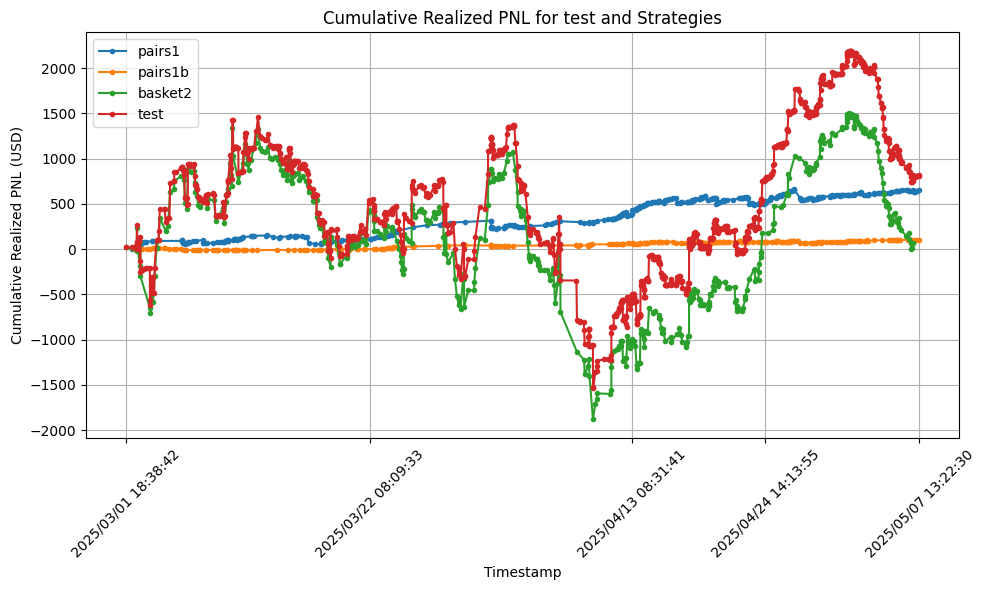

In [51]:
plot_pnl('test') 

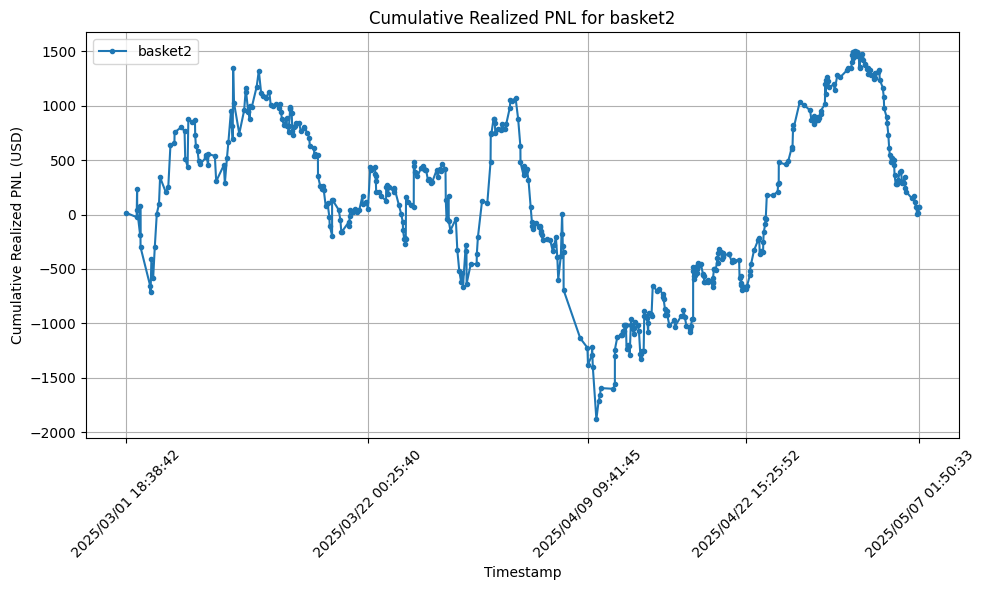

In [52]:
plot_pnl('basket2') 

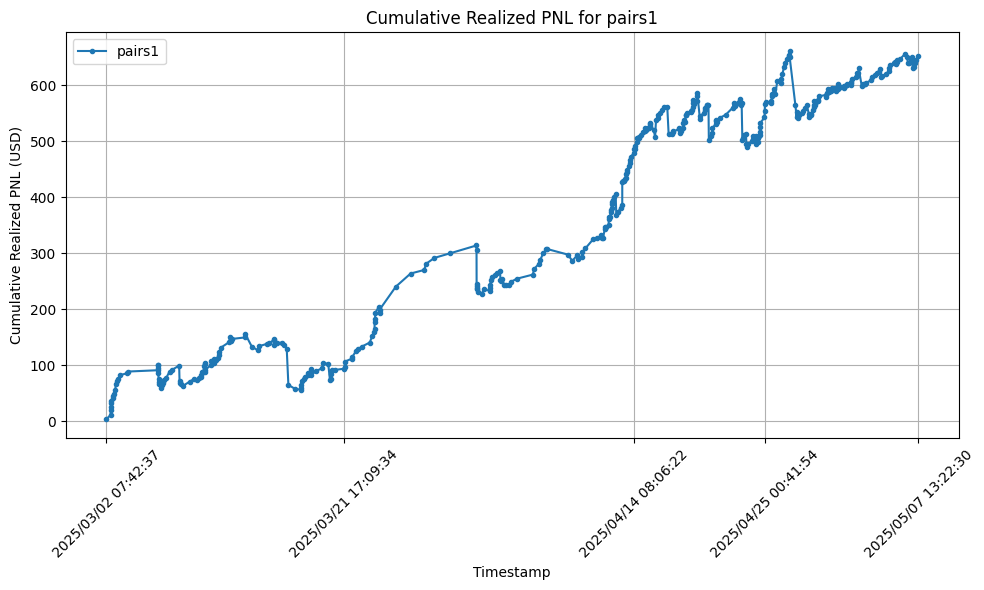

In [53]:
plot_pnl('pairs1') 